# Wind farm integration

An example of a wind farm offering firm power by estimating the expected wind resource and then using a MPC to jointly optimize control of a small gas turbine and storage.

In [12]:
%matplotlib inline
import datetime
import pandas as pd
import matplotlib
import numpy as np
import cvxpy as cvx
from matplotlib import pyplot as plt

# import local copy of cvxpower
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from cvxpower import *

matplotlib.rc("figure", figsize=(16,6))
matplotlib.rc("lines", linewidth=2)
matplotlib.rc("font", serif='Computer Modern Roman')

graphdir = '../fig/'
figsize=(10,2)

## TODOs

- keep simplifying the code. it must become much easier to read!
- make a cell at the start with ALL the constants/parameters and their units!
- make better plot/comparisons
- test on two separate weeks? or on the whole year...

## Load predictive model 

In [13]:
baseline = pd.read_pickle('wind_baseline.pickle')
autoreg_residual_params = pd.read_pickle('residual_params.pickle')
sigma_residual_errors = pd.read_pickle('sigma_epsilon.pickle')
train = pd.read_pickle('wind_power_train.pickle')
test = pd.read_pickle('wind_power_test.pickle')
p_wind = pd.concat([train,test])
del train
del test

## Set constants and test period

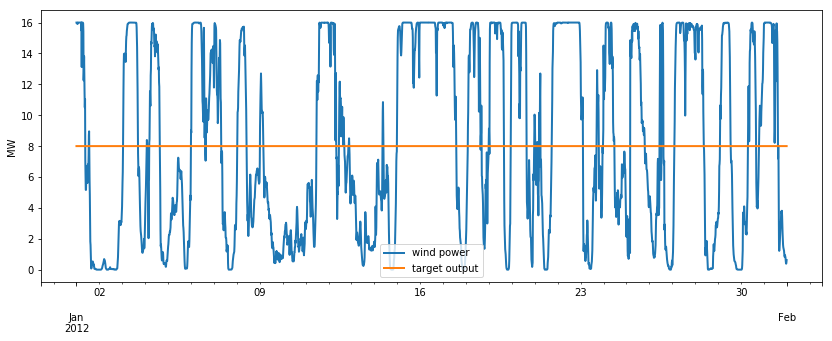

In [40]:
# CONSTANTS
storage_capacity = 100 # MWh
initial_storage = storage_capacity // 2
battery_charge_max = storage_capacity /10. # a full charge in 10 hours
battery_discharge_max = storage_capacity /10. # a full discharge in 10 hours
wind_power_max = 16.
wind_power_min = 0.

gas_power_max = 12  #MW
gas_power_min = 0.01 #MW
gas_alpha = .5
gas_beta = 80.

# len of each time interval, in hours
len_interval = (baseline.index[1] - baseline.index[0]).seconds/3600
intervals_per_day = int(24 / len_interval)

# analysis horizon
T = intervals_per_day * 31

# we test on the first off-sample month
sim_start_time = 70080 # Timestamp('2012-01-01 00:00:00')
sim_end_time = sim_start_time + T

assert len(baseline) > sim_end_time
assert baseline.index[sim_start_time].year >= 2012 # out of sample


#wind_power_available = test[target_output.index]

target_output = pd.Series(data= 8., #baseline[sim_start_time:sim_end_time].mean(),
                          index=baseline[sim_start_time:sim_start_time + 2*T].index)

p_wind[sim_start_time:sim_end_time].plot(figsize=(14,5), label='wind power')
target_output[:T].plot(label='target output')
plt.ylabel('MW')
plt.legend()

### Cost of MWh produced by gas turbine 

Text(0,0.5,'$ / MWh')

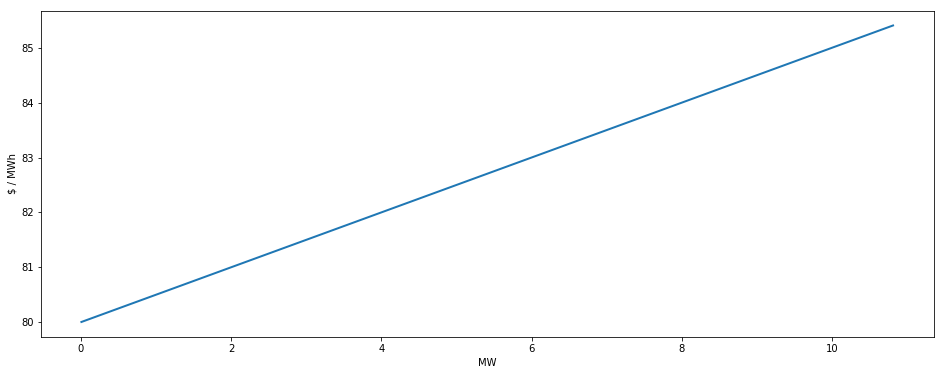

In [24]:
def cost_per_unit(power):
    return (gas_alpha * power**2 + gas_beta * power)/power

x = np.arange(gas_power_min, gas_power_max, gas_power_max/10)
plt.plot(x, cost_per_unit(x))
plt.xlabel('MW')
plt.ylabel('$ / MWh')

## Prescient DOPF

In [25]:
def make_network(T, K):
    """Define network and parameters for data."""
    target_output = Parameter((T,K))
    wind_power_available = Parameter((T,K))
    initial_storage = Parameter((1,1))
    final_storage = Parameter((1,1))
    out = FixedLoad(power = target_output, name="Target output")
    wind_gen = Generator(alpha=0, beta=0, power_min=0, 
                         power_max=wind_power_available, name="Wind generator")
    gas_gen = Generator(alpha=gas_alpha, beta=gas_beta, 
                        power_min=gas_power_min, power_max=gas_power_max, name="Gas generator",
                       len_interval = len_interval)
    storage = Storage(discharge_max=battery_discharge_max, charge_max=battery_charge_max, 
                      energy_max=storage_capacity, 
                      energy_init = initial_storage, 
                      energy_final = final_storage,
                     len_interval = len_interval)
    net = Net([wind_gen.terminals[0],
               gas_gen.terminals[0],
               storage.terminals[0],
               out.terminals[0]])
    dopf_network = Group([wind_gen, gas_gen, storage, out], [net])
    dopf_network.init_problem(time_horizon=T, num_scenarios = K)
    return target_output, wind_power_available, initial_storage, final_storage, dopf_network

In [41]:
target_output_par, wind_power_available_par, initial_storage_par, final_storage_par, dopf_network = \
    make_network(T, 1)
    
target_output_par.value = np.matrix(target_output[:T]).T
wind_power_available_par.value = np.matrix(p_wind[sim_start_time:sim_end_time]).T
initial_storage_par.value = np.matrix(initial_storage)
final_storage_par.value = np.matrix(initial_storage)

cost_dopf = dopf_network.problem.solve(solver='ECOS', verbose=True)
#print(cost_dopf)


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.142e+06  -1.703e+07  +2e+07  3e-02  7e-02  1e+00  7e+02    ---    ---    2  1  - |  -  - 
 1  +6.896e+05  -1.024e+07  +1e+07  2e-02  4e-02  6e+01  4e+02  0.5022  2e-01   2  2  2 |  0  0
 2  +5.969e+05  -2.805e+06  +4e+06  6e-03  1e-02  9e+01  1e+02  0.8738  2e-01   2  2  2 |  0  0
 3  +5.792e+05  -2.661e+06  +3e+06  5e-03  1e-02  9e+01  1e+02  0.1697  6e-01   2  2  2 |  0  0
 4  +4.369e+05  -1.456e+06  +2e+06  3e-03  6e-03  7e+01  6e+01  0.7803  4e-01   2  1  1 |  0  0
 5  +3.084e+05  -5.415e+05  +9e+05  1e-03  3e-03  3e+01  3e+01  0.5914  9e-02   2  2  2 |  0  0
 6  +3.114e+05  -4.762e+05  +8e+05  1e-03  3e-03  3e+01  3e+01  0.2244  7e-01   1  1  1 |  0  0
 7  +2.667e+05  -5.249e+04  +3e+05  4e-04  1e-03  1e+01  1e+01  0.7158  2e-01   1  1  1 |  0  0
 8  +2.661e+05  -2.617e+04  +3e+05  4e-04  1e-

In [27]:
def print_and_plot_stats(wind_power_avail, wind_power_used, gas_power, output, cost):
    assert len(output) == len(wind_power_avail)
    assert len(output) == len(wind_power_used)
    assert len(output) == len(gas_power)

    wind_power_avail.plot(label='wind power available', figsize=(14,4), alpha=.8)
    pd.Series(data = wind_power_used, 
              index = wind_power_avail.index).plot(label='wind power used', alpha=.8)
    output.plot(label='target output', style='--', color='k', alpha=.8)
    plt.legend()

    total_output = sum(output)/len(output) 
    total_wind_power_avail = sum(wind_power_avail)/len(output)
    total_gas_gen = sum(gas_power)/len(output)

    print('(Values are daily averages.)\n')
    print('Energy sold:\t\t%.2f MWh\nWind energy avail.:\t%.2f MWh\nGas gener. output:\t%.2f MWh\nWind energy used:\t%.2f MWh\nWind energy lost:\t%.2f MWh' % (
        24*total_output,
        24*total_wind_power_avail,
        24*total_gas_gen,
        24*np.mean(wind_power_used),
        24*(total_wind_power_avail - np.mean(wind_power_used))
    ))

    print('\nEnergy sold (at $80/MWh):    %.2f$' % (24 * total_output *80))
    print('Cost of gas generated energy: %.2f$' % (24 * cost / (len(output))))

(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	23.09 MWh
Wind energy used:	168.91 MWh
Wind energy lost:	33.45 MWh

Energy sold (at $80/MWh):    15360.00$
Cost of gas generated energy: 1882.67$


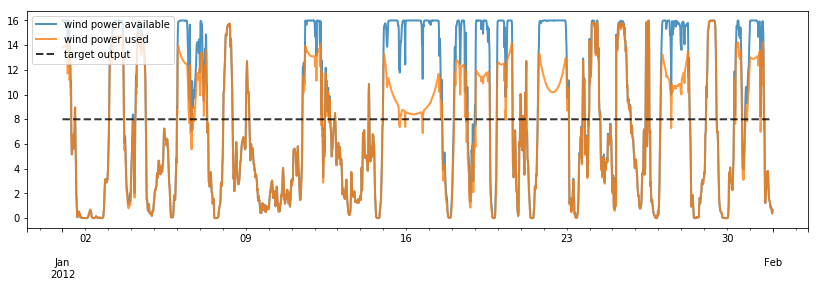

In [28]:
wind_gen, gas_gen, storage = dopf_network.devices[0:3]


print_and_plot_stats(wind_power_avail = p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -dopf_network.results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -dopf_network.results.power[(gas_gen,0)], 
                     output = target_output, 
                     cost = cost_dopf)

In [29]:
def plot(results, target_output, energy_stored, methodname):
    ax = results.plot(figsize=(12,6), 
                              index=target_output.index)
    ax[0].set_ylabel('MW')
    ax[1].set_ylabel('$ / MWh')
    plt.savefig(graphdir+'wind_%s_results.pdf'%methodname)
    plt.figure(figsize=(12,3))
    plt.plot(target_output.index, energy_stored)
    plt.ylabel("MWh")
    plt.savefig(graphdir+'wind_%s_energy.pdf'%methodname)

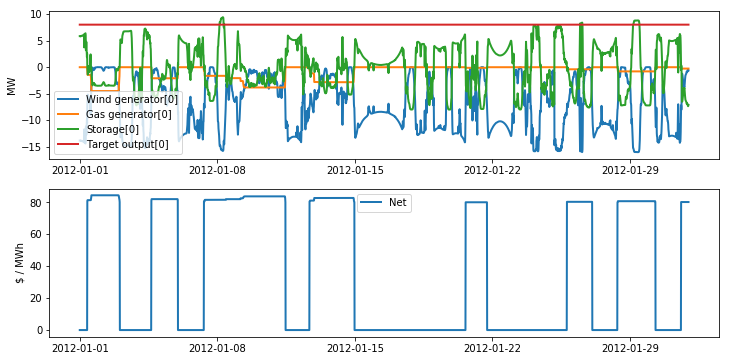

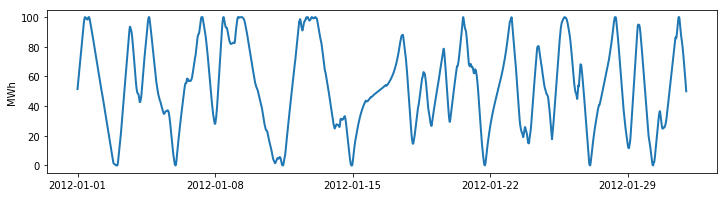

In [30]:
wind_gen, gas_gen, storage = dopf_network.devices[0:3]

plot(dopf_network.results, baseline[sim_start_time:sim_end_time], storage.energy.value, 'dopf')

## Prescient MPC 

In [42]:
T_MPC = intervals_per_day

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, MPC_network = \
    make_network(T_MPC, 1)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)

def make_forecasts(t):
    target_output_MPC.value = np.matrix(target_output[t:t+T_MPC]).T
    wind_power_available_MPC.value = np.matrix(p_wind[sim_start_time+t:sim_start_time+t+T_MPC]).T
    
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    #final_storage_MPC.value = np.matrix(energy_stored[t]) # change this to change MPC behavior
    
cost_prescient_MPC, prescient_MPC_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')


100%|██████████| 2976/2976 [03:52<00:00, 13.25it/s]


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	25.33 MWh
Wind energy used:	167.52 MWh
Wind energy lost:	34.84 MWh

Energy sold (at $80/MWh):    15360.00$
Cost of gas generated energy: 2069.55$


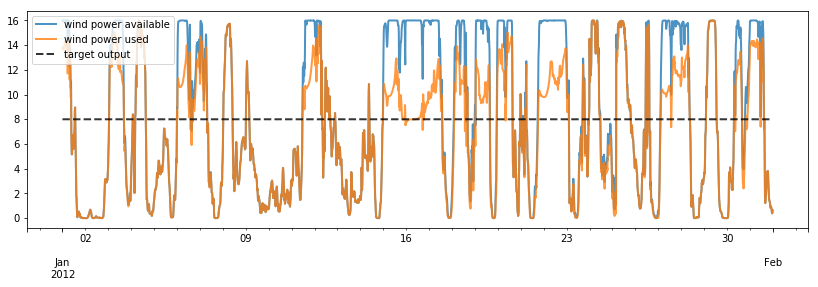

In [44]:
wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -prescient_MPC_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -prescient_MPC_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_prescient_MPC)

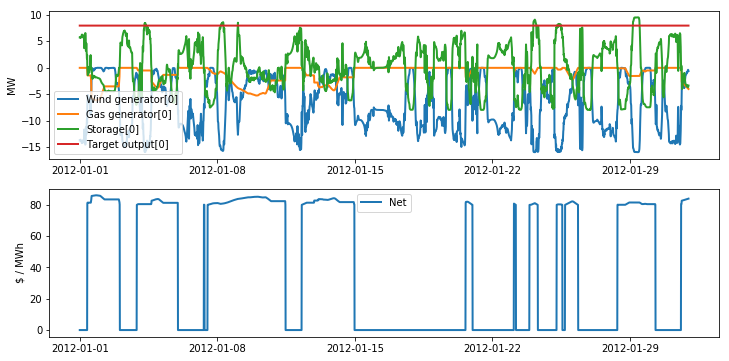

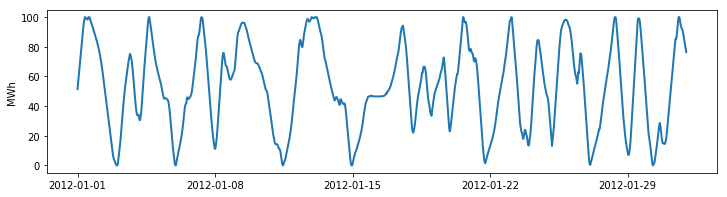

In [47]:
plot(prescient_MPC_results,  baseline[sim_start_time:sim_end_time], energy_stored, 'presc_mpc')

## MPC with baseline and residual AR

In [48]:
T_MPC = intervals_per_day

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, MPC_network = \
    make_network(T_MPC, 1)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)

def predict_wind(p_wind, baseline, autoreg_residual_params, t, M, L, K = 1):
    past = p_wind[t-M:t]
    past_baseline = baseline[t-M:t]
    fut_baseline = baseline[t:t+L]
    pred = list(reversed(past-past_baseline)) @ autoreg_residual_params
    pred = pd.Series(pred, index=fut_baseline.index)
    pred = np.maximum(wind_power_min, pred + fut_baseline)
    pred = np.minimum(wind_power_max, pred + fut_baseline)
    return pred

def make_forecasts(t):
    target_output_MPC.value = np.matrix(target_output[t:t+T_MPC]).T
    wind_power_available_MPC.value = np.matrix(np.concatenate([
        [p_wind[sim_start_time+t]],
        predict_wind(p_wind, baseline, autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC)[:-1]])).T
        
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    #final_storage_MPC.value = np.matrix(energy_stored[t]) # change this to change MPC behavior
    
cost_AR_MPC, AR_MPC_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

100%|██████████| 2976/2976 [04:04<00:00, 12.18it/s]


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	46.41 MWh
Wind energy used:	143.97 MWh
Wind energy lost:	58.38 MWh

Energy sold (at $80/MWh):    15360.00$
Cost of gas generated energy: 3857.74$


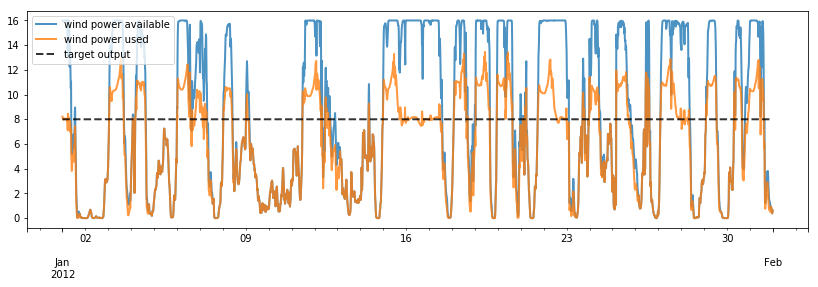

In [49]:
wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -AR_MPC_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -AR_MPC_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_AR_MPC)

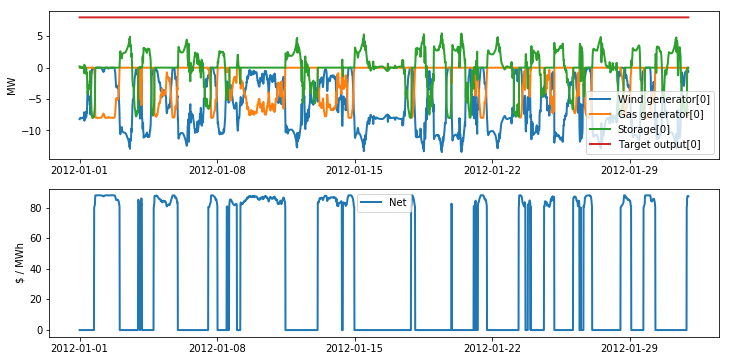

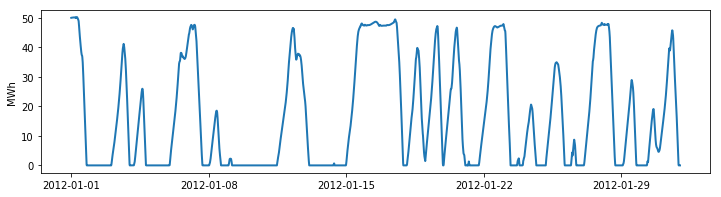

In [50]:
plot(AR_MPC_results,  baseline[sim_start_time:sim_end_time], energy_stored, 'AR_mpc')

### Diagnostic 

In [43]:
# t = sim_start_time

# past = p_wind[t-intervals_per_day:t]
# future = p_wind[t:t+intervals_per_day]

# past_baseline = baseline[t-intervals_per_day:t]
# fut_baseline = baseline[t:t+intervals_per_day]

# past.plot()
# future.plot()

# past_baseline.plot()
# fut_baseline.plot()

# plt.figure()

# (past-  past_baseline).plot()
# (future-  fut_baseline).plot()

# pred = predict_wind(p_wind, baseline, autoreg_residual_params, t, intervals_per_day, intervals_per_day)

# (pred - fut_baseline).plot(style='--')

# plt.figure()
# past.plot()
# future.plot()
# (pred).plot()

## Robust MPC 

In [51]:
T_MPC = intervals_per_day
K = 10

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, MPC_network = \
    make_network(T_MPC, K)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)


def make_forecasts(t):
    target_output_MPC.value = np.tile(target_output[t:t+T_MPC], (K,1)).T
#     wind_power_available_MPC.value = np.tile(np.concatenate([
#         [p_wind[sim_start_time+t]],
#         predict_wind(p_wind, baseline, autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC)[:-1]]),
#                                              (K,1)).T
    # draw scenarios
    scenarios = np.hstack([np.matrix([p_wind[sim_start_time+t]]*K).T,
                           np.random.multivariate_normal(predict_wind(p_wind, baseline, 
                            autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC), 
                             sigma_residual_errors, K)[:,:-1]])
    scenarios = np.maximum(wind_power_min, scenarios)
    scenarios = np.minimum(wind_power_max, scenarios)
    wind_power_available_MPC.value = scenarios.T
    
        
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0,0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    
cost_robust_MPC, MPC_robust_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

100%|██████████| 2976/2976 [20:39:25<00:00,  1.11s/it]     


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	36.05 MWh
Wind energy used:	154.55 MWh
Wind energy lost:	47.81 MWh

Energy sold (at $80/MWh):    15360.00$
Cost of gas generated energy: 2997.76$


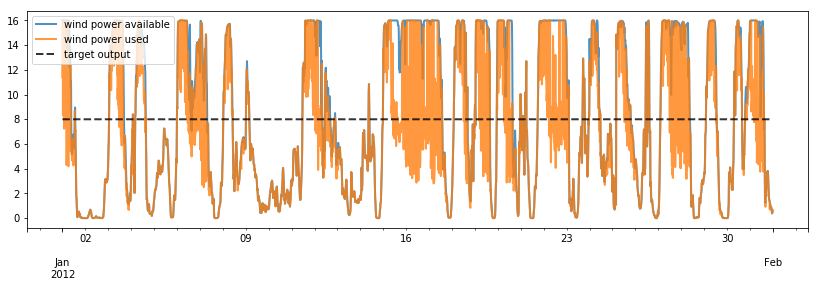

In [52]:
wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -MPC_robust_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -MPC_robust_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_robust_MPC)

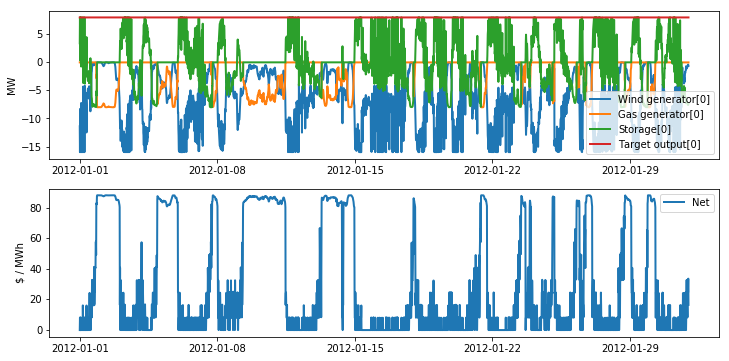

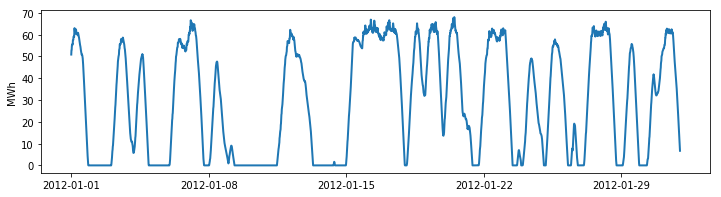

In [53]:
plot(MPC_robust_results,  baseline[sim_start_time:sim_end_time], energy_stored, 'robust_mpc')